In [19]:
from src.util.io import load_sampled_fccs, load_reference_fccs

sampled_fcc_komkova = load_sampled_fccs('../../../data/mc/mc_komkova.mat')
ref_fcc_komkova = load_reference_fccs('../../../data/fcc/ref_fccs_komkova.txt')

sampled_fcc_shestov = load_sampled_fccs('../../../data/mc/mc_shestov.mat')
ref_fcc_shestov = load_reference_fccs('../../../data/fcc/ref_fcc_shestov.txt')


In [20]:
import matplotlib.pyplot as plt


def plot_fcc_distribution(sampled_fccs, ref_fccs, rows, columns, name, figsize=(9, 5)):
    plt.style.use('default')
    fig, axes = plt.subplots(len(rows), len(columns), figsize=figsize, dpi=300, sharey=False)

    for i, row in zip(rows, axes):
        for j, ax in zip(columns, row):
            x = sampled_fccs[i, j, :]
            ax.hist(x, bins=50, density=True, range=(-1, 1))
            ax.axvline(ref_fccs.iat[i, j], color='r', linewidth=1, alpha=0.4)

            ax.set_xticks([])
            ax.set_yticks([])

    for i, rxn_index in enumerate(rows):
        title = ref_fccs.index[rxn_index]
        axes[i, 0].set_ylabel(title, va="center", ha="right", rotation='horizontal')

    for i, rxn_index in enumerate(columns):
        title = ref_fccs.index[rxn_index]
        axes[-1, i].set_xlabel(title)

    path = '../../../out/fccs_' + name
    plt.savefig(path, bbox_inches='tight', pad_inches=0.05, dpi=600)
    plt.show()


## Fig. 10 Distribution of FCCs for the GEM-embedded model. 

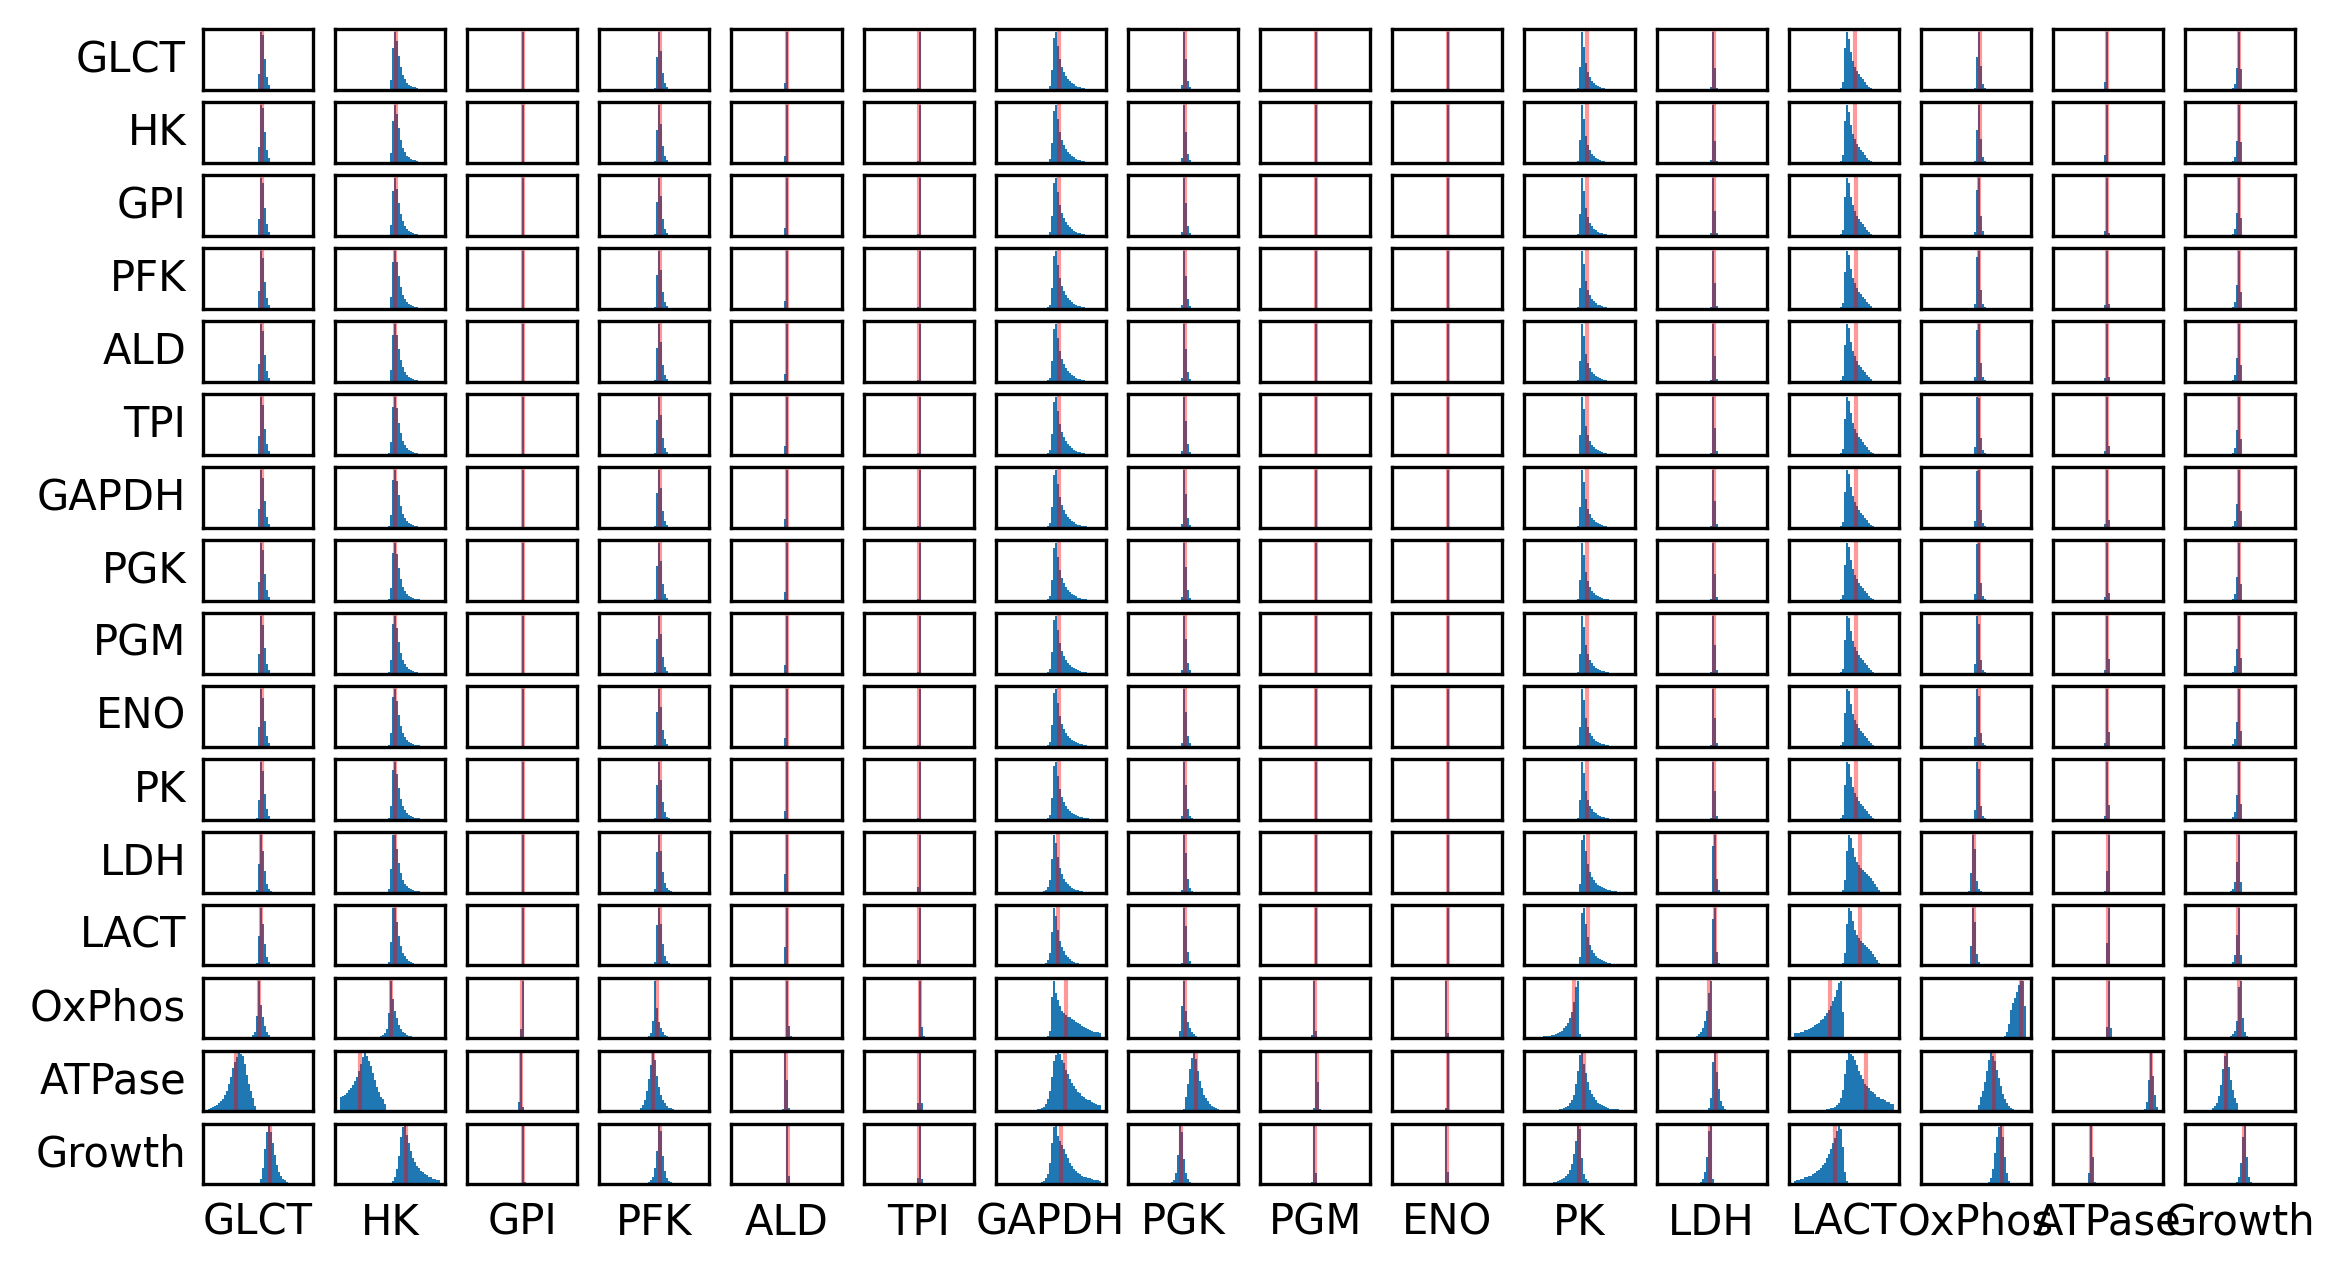

In [21]:
rxn_index = [index for (index, rxn_id) in enumerate(ref_fcc_komkova.index) if rxn_id not in ['AK', 'OXYT']]
plot_fcc_distribution(sampled_fcc_komkova, ref_fcc_komkova, rxn_index, rxn_index, 'komkova')

## Fig. S3 Distribution of FCCs for the Shestov-derived model.  

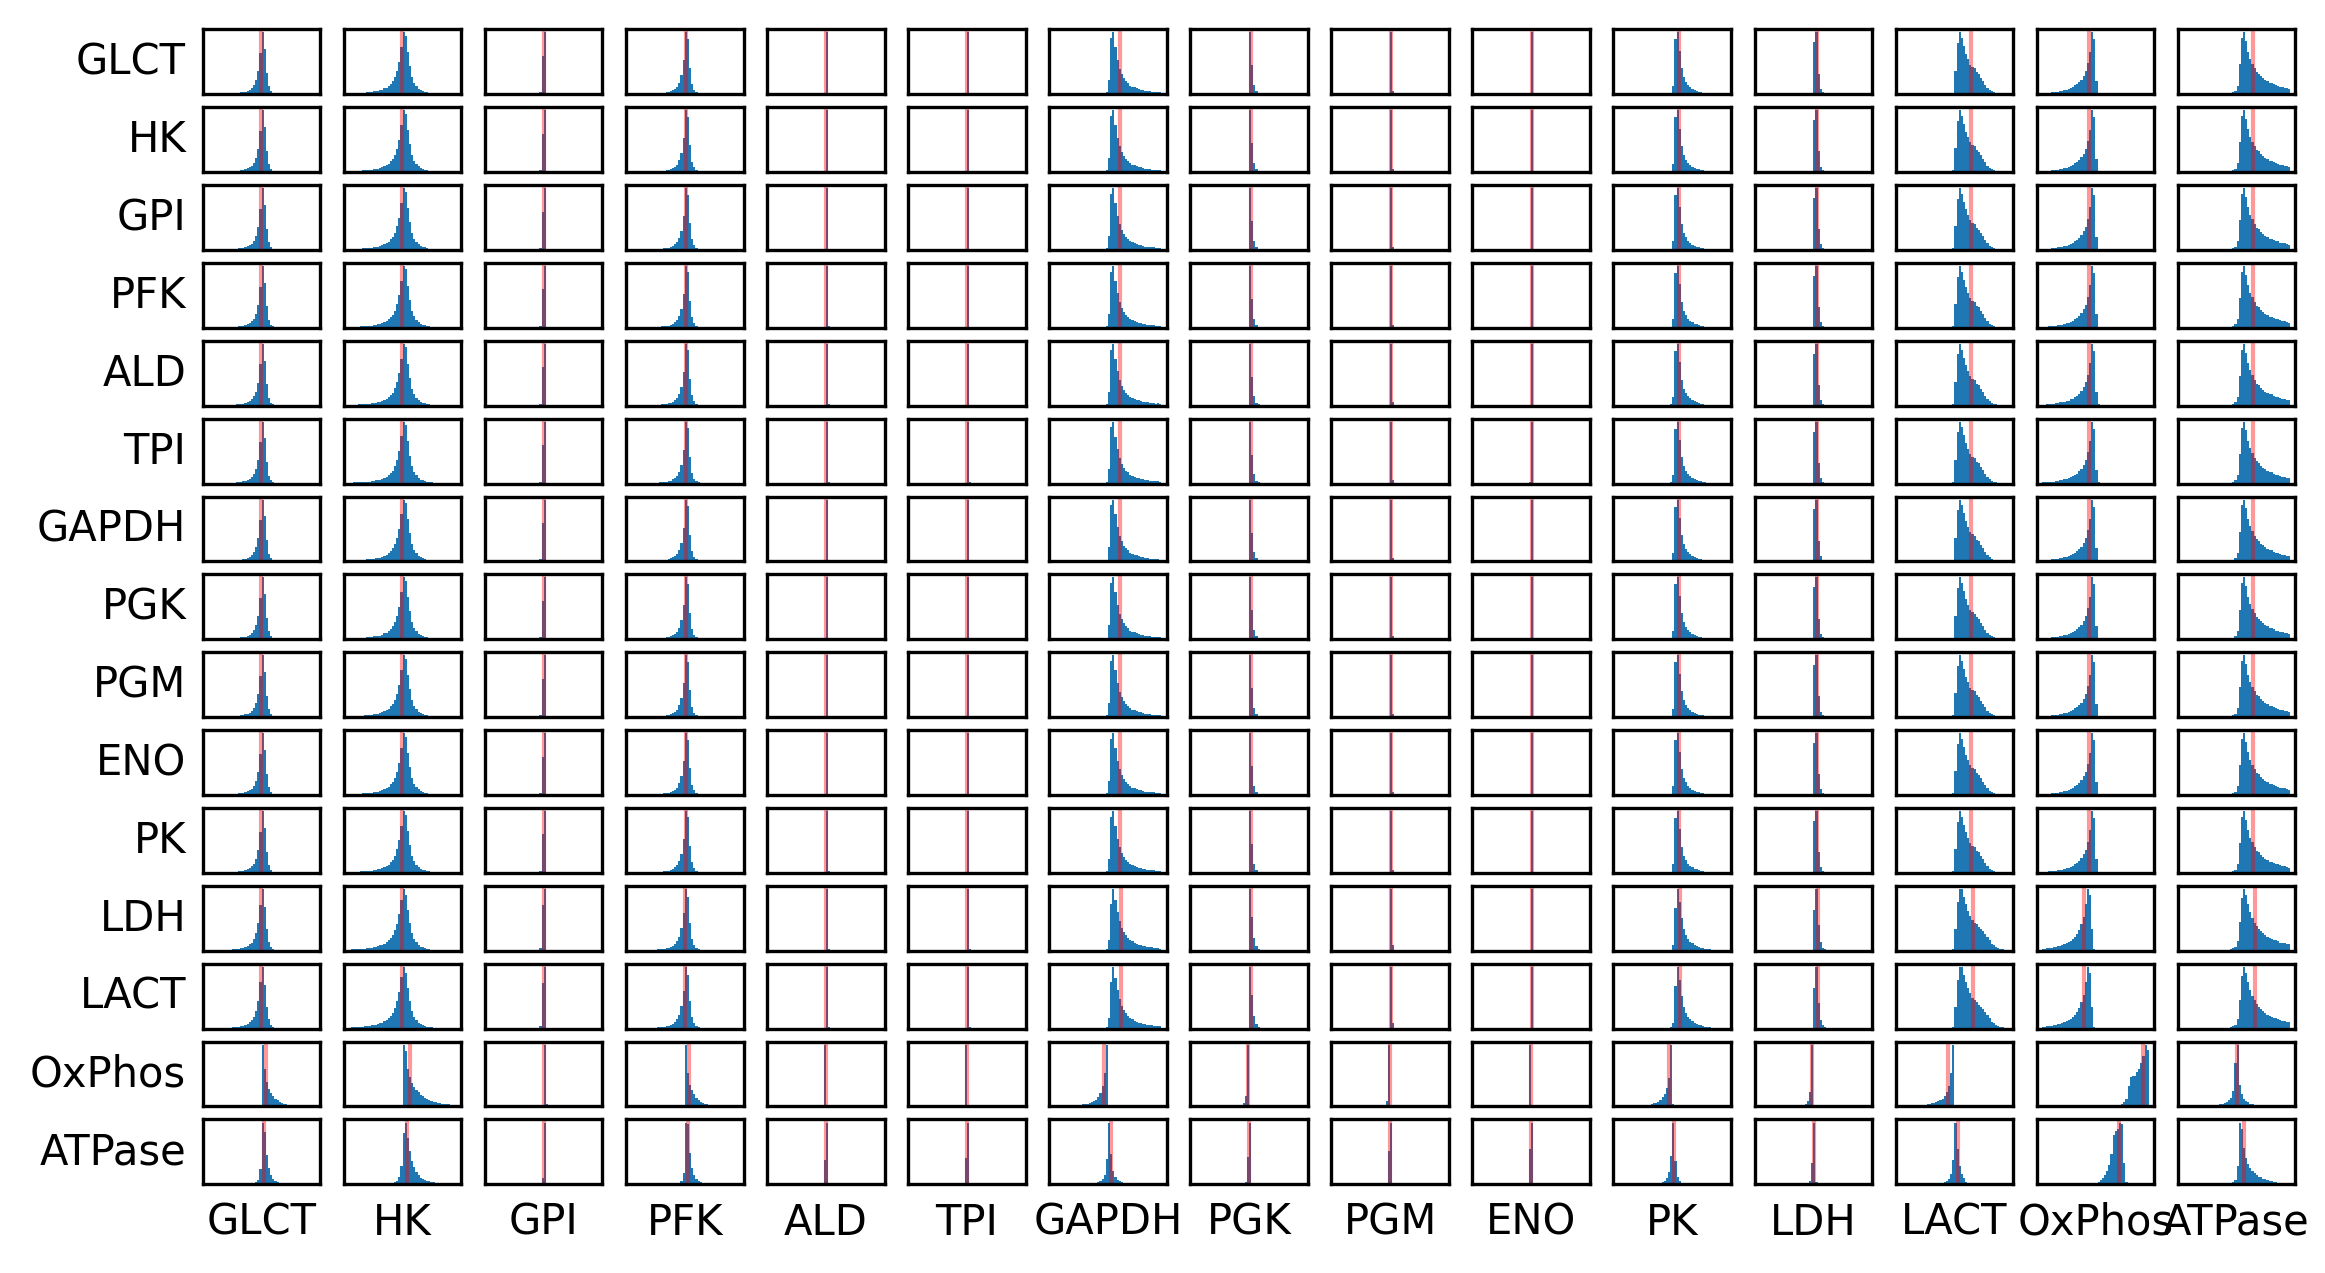

In [22]:
all_relevant = [index for (index, rxn_id) in enumerate(ref_fcc_shestov.index) if rxn_id not in ['AK', 'OXYT']]
plot_fcc_distribution(sampled_fcc_shestov, ref_fcc_shestov, all_relevant, all_relevant, 'shestov')


In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def reject_outliers(data):
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)

    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return data[np.logical_and(data >= lower, data <= upper)]


def plot_violin_distribution(sampled_fcc: np.ndarray, ref_fcc: pd.DataFrame):
    sns.set_style("whitegrid")

    fig = plt.figure(figsize=(5.4, 1.7), dpi=312)

    temp = []
    for i, rxn in enumerate(ref_fcc.index):
        temp.append(reject_outliers(sampled_fcc[i, :]))

    df = pd.DataFrame(data=temp).transpose()
    lw = 0.5
    violin = sns.violinplot(data=df, density_norm='width', linewidth=lw)

    xticks = violin.get_xticks()
    for xtick in xticks:
        value = ref_fcc.iat[xtick]
        plt.hlines(y=value, xmin=xtick - 0.05, xmax=xtick + 0.05, color='r', lw=lw)

    violin.set_xticks(xticks, ref_fcc.index)
    plt.xticks(rotation=45)
    return fig



## Fig. 11

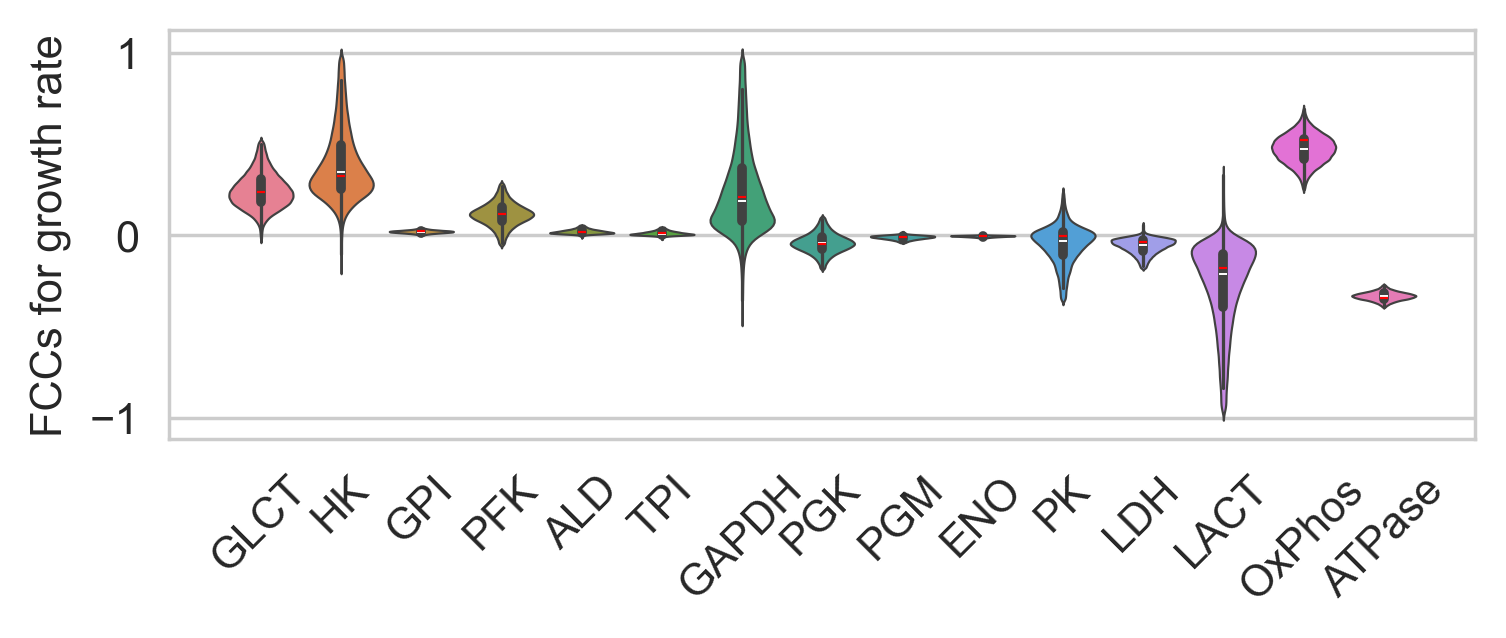

In [24]:
full_index_komkova = ref_fcc_komkova.index

growth_index = full_index_komkova.get_loc('Growth')
columns = [index for (index, rxn_id) in enumerate(ref_fcc_komkova.index) if
           rxn_id not in ['AK', 'OXYT', 'Growth']]
plot_violin_distribution(sampled_fcc_komkova[growth_index, columns, :], ref_fcc_komkova.iloc[growth_index, columns])

plt.ylabel('FCCs for growth rate')
path = '../../../out/fccs_vp_growth_komkova'
plt.savefig(path, bbox_inches='tight', pad_inches=0, dpi=312)
plt.show()


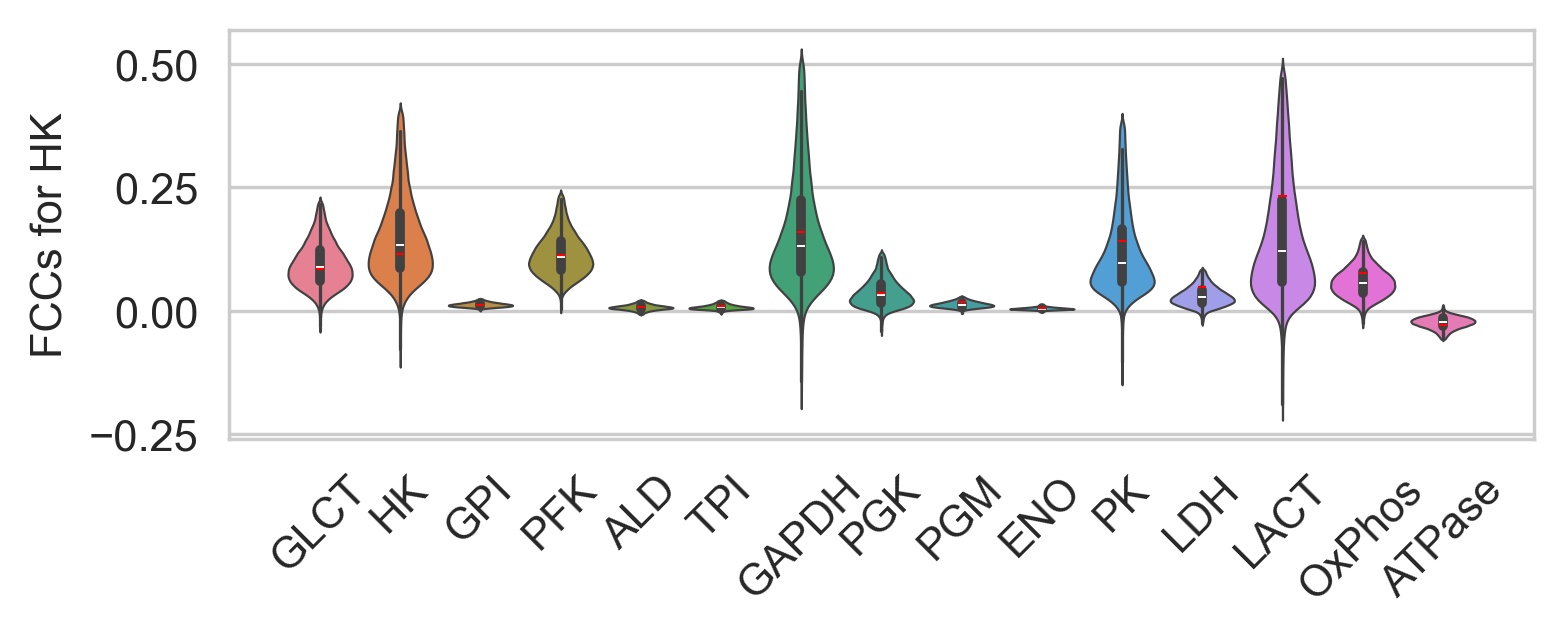

In [25]:
hk_index = full_index_komkova.get_loc('HK')
hk_fcc_sampled = sampled_fcc_komkova[hk_index, columns, :]
hk_fcc_ref = ref_fcc_komkova.iloc[hk_index, columns]

plot_violin_distribution(hk_fcc_sampled, hk_fcc_ref)
plt.ylabel('FCCs for HK')

path = '../../../out/fccs_vp_hk_komkova'
plt.savefig(path, bbox_inches='tight', pad_inches=0, dpi=312)
plt.show()


## Fig. 9 Comparison of the distribution of FCCs for HK flux between the sampled model instances of the Shestov-derived model and the sampled model instances of the GEM-embedded model.


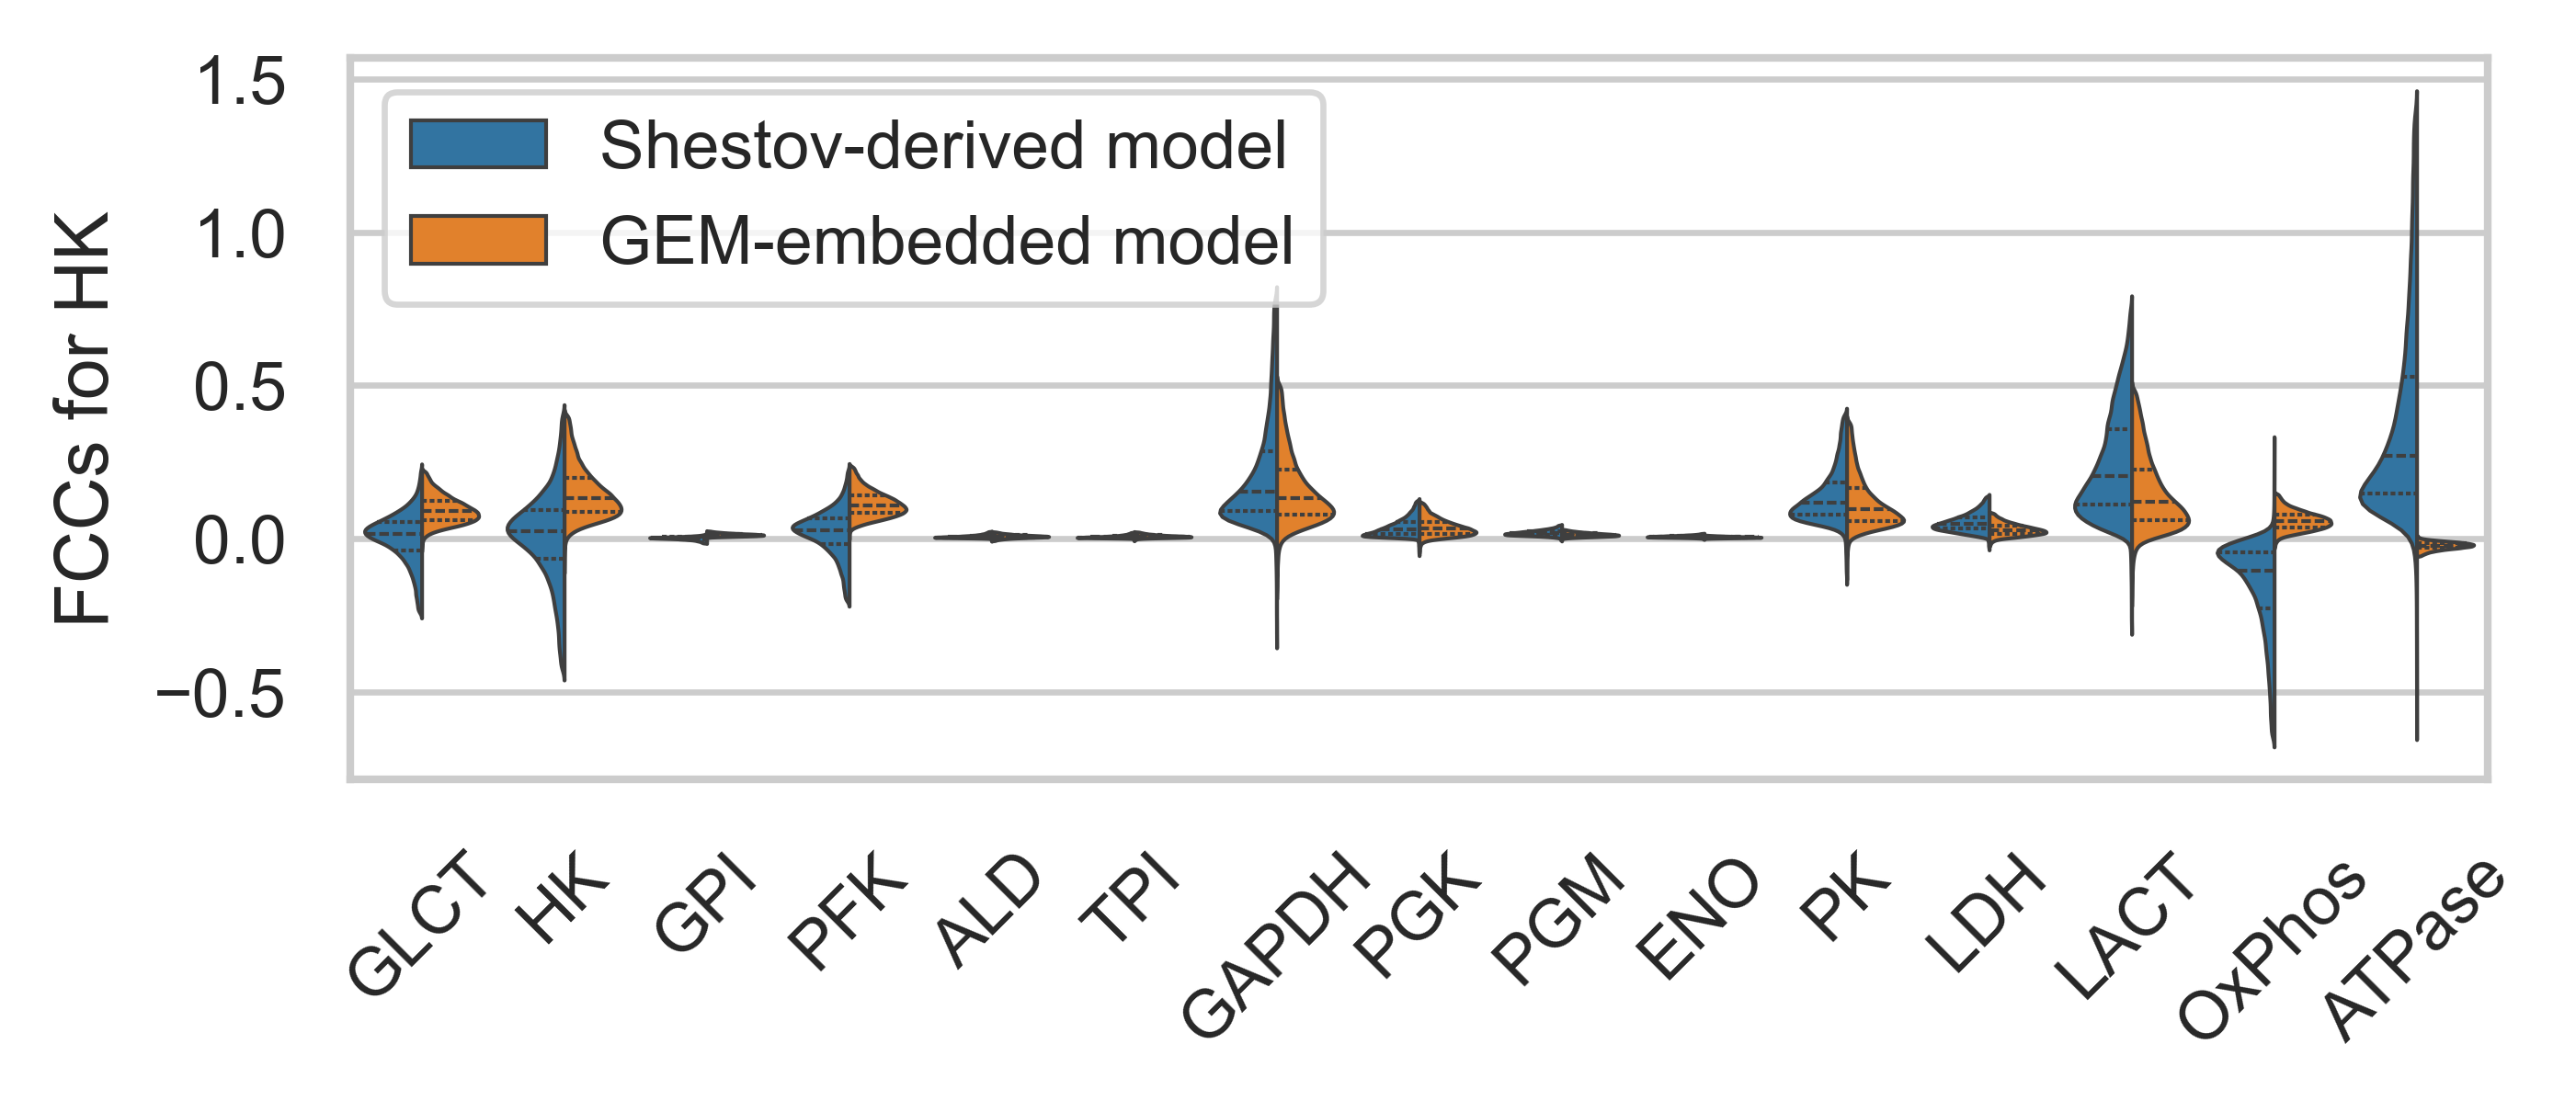

In [26]:
columns = [index for (index, rxn_id) in enumerate(ref_fcc_komkova.index) if
           rxn_id not in ['AK', 'OXYT', 'Growth']]
hk_fcc_sampled_sh = sampled_fcc_shestov[hk_index, columns, :]
hk_fcc_ref_sh = ref_fcc_shestov.iloc[hk_index, columns]

hk_fcc_sampled = sampled_fcc_komkova[hk_index, columns, :]
hk_fcc_ref = ref_fcc_komkova.iloc[hk_index, columns]

sns.set_context('paper')
sns.set_style("whitegrid")
fig = plt.figure(figsize=(5, 1.7), dpi=600)

komkova = {}
for i, rxn in enumerate(hk_fcc_ref.index):
    komkova[rxn] = reject_outliers(hk_fcc_sampled[i, :])

shestov = {}
for i, rxn in enumerate(hk_fcc_ref_sh.index):
    shestov[rxn] = reject_outliers(hk_fcc_sampled_sh[i, :])

df = pd.DataFrame(
    [[label, val, 'GEM-embedded model'] for label, values in komkova.items() for val in values]
    + [[label, val, 'Shestov-derived model'] for label, values in shestov.items() for val in values],
    columns=['label', 'value', 'Model'])
hue_order = ['Shestov-derived model', 'GEM-embedded model']
violin = sns.violinplot(data=df, x='label', y='value', density_norm='width', linewidth=0.5,
                        split=True, hue='Model', hue_order=hue_order, inner='quart')

violin.set(xlabel=None, ylabel='FCCs for HK')
plt.xticks(rotation=45)
plt.legend(loc='upper left')

path = '../../../out/fccs_vp_hk_komkova_vs_shestov'
plt.savefig(path, bbox_inches='tight', transparent=True)
plt.show()
